In [1]:
import os
import shutil
from glob import glob

#datapath = '/data/FoodDetection/Object_Detection/yolov5-test/dataset/RDProject7_folder/images/'
datapath = '/data/Data_data/FoodDetection/data/food_detection/LunchBox/train/images/'

data_list = glob(datapath + '*')
#print(data_list)
f = open('./gpu01_dataset/train.txt', "w")
for i in data_list:
    f.write(''.join(i) + '\n')

In [2]:
datapath = '/data/Data_data/FoodDetection/data/food_detection/LunchBox/val/images/'

data_list = glob(datapath + '*')
#print(data_list)
f = open('./gpu01_dataset/val.txt', "w")
for i in data_list:
    f.write(''.join(i) + '\n')

In [ ]:
python train.py --img 500 --batch 8 --epochs 500 --data /data/Data_data/FoodDetection/Object_Detection/yolov5-test/yolov5/gpu01_dataset/dki1000_all.yaml --weights /data/FoodDetection/Object_Detection/yolov5-test/yolov5/yolov5x.pt --device 0,1

In [ ]:
CUDA_VISIBLE_DEVICES=0,1 python train.py --img 500 --batch 8 --epochs 500 --data ./gpu01_dataset/dki1000_all.yaml --weights /data/FoodDetection/Object_Detection/yolov5-test/yolov5/yolov5x.pt

In [ ]:
python train.py --img 500 --batch 8 --epochs 500 --data /data/FoodDetection/Object_Detection/yolov5-test/yolov5/gpu01_dataset/dki1000_all.yaml --weights /data/FoodDetection/Object_Detection/yolov5-test/yolo/yolov5/yolov5x.pt --device 2,3

In [ ]:
CUDA_VISIBLE_DEVICES=0,1 python train.py --img 500 --batch 8 --epochs 500 --data /data/FoodDetection/Object_Detection/yolov5-test/yolov5/gpu01_dataset/dki1000_all.yaml --weights /data/FoodDetection/Object_Detection/yolov5-test/yolo/yolov5/yolov5x.pt

In [1]:
2*(0.9144*0.9984)/(0.9144+0.9984)

0.954555583437892

In [13]:
!python detect.py --weights /data/FoodDetection/Object_Detection/yolov5-test/yolov5/runs/exp113/weights/food409_best.pt --img 640 --conf 0.25 --source /data/Data_data/FoodDetection/data/food_detection/LunchBox/data_test

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', img_size=640, iou_thres=0.5, output='inference/output', save_txt=False, source='/data/Data_data/FoodDetection/data/food_detection/LunchBox/data_test', update=False, view_img=False, weights=['/data/FoodDetection/Object_Detection/yolov5-test/yolov5/runs/exp113/weights/food409_best.pt'])
Using CUDA device0 _CudaDeviceProperties(name='Tesla V100-PCIE-16GB', total_memory=16130MB)
           device1 _CudaDeviceProperties(name='Tesla V100-PCIE-16GB', total_memory=16130MB)
           device2 _CudaDeviceProperties(name='Tesla V100-PCIE-16GB', total_memory=16130MB)
           device3 _CudaDeviceProperties(name='Tesla V100-PCIE-16GB', total_memory=16130MB)

Fusing layers... 
Model Summary: 284 layers, 9.51129e+07 parameters, 0 gradients
image 1/870 /data/Data_data/FoodDetection/data/food_detection/LunchBox/data_test/dki_CU_12찬 한판 도시락_1_900007.jpg: pred:  tensor([[ 90.12500, 108.00000, 580.00000, 414.00000,   0.

In [ ]:
/data/FoodDetection/Object_Detection/yolov5-test/yolov5/runs/exp113/weights/food409_best.pt

### yolo 모델 inference를 위한 classification 모델

https://pytorch.org/vision/stable/models.html

https://hayunjong83.tistory.com/47

https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5

https://ndb796.tistory.com/373

https://stackoverflow.com/questions/67250023/related-to-subsetrandomsampler

https://towardsdatascience.com/pytorch-basics-sampling-samplers-2a0f29f0bf2a

https://blog.naver.com/PostView.nhn?isHttpsRedirect=true&blogId=chrhdhkd&logNo=221470462702&parentCategoryNo=87&categoryNo=&viewDate=&isShowPopularPosts=true&from=search

https://quokkas.tistory.com/37

https://jdjin3000.tistory.com/17

https://blog.naver.com/PostView.nhn?blogId=ckdgus1433&logNo=221407059199

https://www.analyticsvidhya.com/blog/2021/04/10-pytorch-transformations-you-need-to-know/

https://discuss.pytorch.org/t/changing-a-linear-layer-in-pretrained-model-changes-activation/66949

https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html

https://blog.nerdfactory.ai/2021/02/23/image-classification-transfer-learning-with-custom-data.html

https://pypi.org/project/vision-transformer-pytorch/

https://dacon.io/codeshare/3105

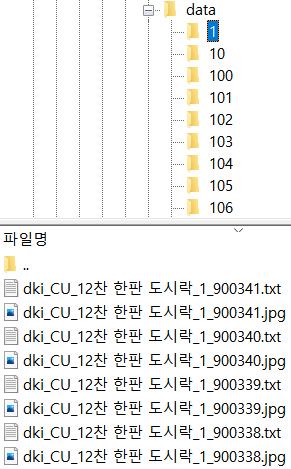

### 위와 같이 클래스 별로 파일이 들어가도록 폴더를 짜야한다.

이미지와 다른 파일들이 섞여 있어도 datasets.ImageFolder에서 이미지만 뽑아낸다.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import numpy as np
import os
import time
import copy

from tqdm import tqdm

In [2]:
torch.__version__

'1.7.1+cu101'

In [3]:
"GPU" if torch.cuda.is_available() else "cpu"

'GPU'

### SubsetRandomSampler로 train, val 분리

In [180]:
# 구지 train_transforms, val_transforms을 따로 둬야하나?

def SubsetRandomSampler_train_val(datadir, valid_size = .1):
    
    train_transforms = transforms.Compose([transforms.Resize((640,640)),
                                       transforms.ToTensor(),
                                       ])
    val_transforms = transforms.Compose([transforms.Resize((640,640)),
                                      transforms.ToTensor(),
                                      ])
    
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    val_data = datasets.ImageFolder(datadir,
                    transform=val_transforms)
    
    num_train = len(train_data)
    print('num_train:', num_train)
    indices = list(range(num_train))
#     print('indices: ', indices)
    split = int(np.floor(valid_size * num_train)) # np.floor는 반올림하는 함수다.
    print('split: ', split)
    np.random.shuffle(indices)
#     print('shuffle_indices: ', indices)
    
    train_idx, val_idx = indices[split:], indices[:split]
    
    from torch.utils.data.sampler import SubsetRandomSampler
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    
    train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                               sampler=train_sampler,
                                               shuffle=False,
                                               batch_size=32)
    val_loader = torch.utils.data.DataLoader(dataset=val_data,
                                             sampler=val_sampler,
                                             shuffle=False,
                                             batch_size=32)
    
    print('len(train_loader): ', len(train_loader), ', len(val_loader): ', len(val_loader))
    
    return train_data, train_loader, val_data, val_loader


transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
transforms.CenterCrop(500),
transforms.GaussianBlur(kernel_size=501)
transforms.RandomResizedCrop(size=500, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
transforms.RandomVerticalFlip(p=1),
transforms.RandomHorizontalFlip(p=1),
transforms.GaussianBlur(kernel_size=501), 이게 속도가 엄청 느리다.

In [3]:
# dataset_transforms 하나로 뒀다.

def SubsetRandomSampler_train_val(datadir, valid_size = .1):
    
    
    '''
    Augmentation에 관한 공식 자료
    https://pytorch.org/vision/stable/transforms.html
    '''
    dataset_transforms = transforms.Compose([transforms.Resize((640,640)),
                                             transforms.ToTensor(),
                                             transforms.CenterCrop(500),
                                             transforms.ColorJitter(brightness=0.2),
                                             transforms.RandomRotation(degrees=180),
                                             transforms.RandomVerticalFlip(p=1),
                                             transforms.RandomHorizontalFlip(p=1)])
    
    dataset = datasets.ImageFolder(datadir,       
                    transform=dataset_transforms)
    
    num_dataset = len(dataset)
    print('num_dataset:', num_dataset)
    indices = list(range(num_dataset))
#     print('indices: ', indices)
    split = int(np.floor(valid_size * num_dataset)) # np.floor는 반올림하는 함수다.
    print('split: ', split)
    np.random.shuffle(indices)
#     print('shuffle_indices: ', indices)
    
    train_idx, val_idx = indices[split:], indices[:split]
    print('len(train_idx): ', len(train_idx), ', len(val_idx): ', len(val_idx))
    
    from torch.utils.data.sampler import SubsetRandomSampler
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    
    train_loader = torch.utils.data.DataLoader(dataset=dataset,
                                               sampler=train_sampler,
                                               shuffle=False,
                                               batch_size=32)
    val_loader = torch.utils.data.DataLoader(dataset=dataset,
                                             sampler=val_sampler,
                                             shuffle=False,
                                             batch_size=32)
    
    print('len(train_loader): ', len(train_loader), ', len(val_loader): ', len(val_loader))
    
    return dataset, train_loader, val_loader


In [4]:
data_dir = '/data/Data_data/FoodDetection/data/food_detection/LunchBox/data'
dataset, train_loader, val_loader = SubsetRandomSampler_train_val(data_dir, .1)

num_dataset: 17704
split:  1770
len(train_idx):  15934 , len(val_idx):  1770
len(train_loader):  498 , len(val_loader):  56


### torch.utils.data.random_split으로 분리

In [215]:
def random_split_train_val(datadir, valid_size = .1):
    
    dataset_transforms = transforms.Compose([transforms.Resize((640,640)),
                                       transforms.ToTensor(),
                                       ])
    
    
    
    dataeset = datasets.ImageFolder(datadir,
                                transform=dataset_transforms)
    
    dataset_num = len(dataset)
    val_num = int(np.floor(valid_size * dataset_num))
    train_num = dataset_num-val_num
    
    dataset_train, dataset_valid = torch.utils.data.random_split(dataeset, (train_num, val_num))
    print('len(dataset_train): ', len(dataset_train), ', len(dataset_valid): ', len(dataset_valid))
    
    train_loader = torch.utils.data.DataLoader(dataset=dataset_train,
                                               shuffle=False,
                                               batch_size=32)
    val_loader = torch.utils.data.DataLoader(dataset=dataset_valid,
                                             shuffle=False,
                                             batch_size=32)
    
    print('len(train_loader): ', len(train_loader), ', len(val_loader): ', len(val_loader))
    
    return dataeset, train_loader, val_loader

In [216]:
data_dir = '/data/Data_data/FoodDetection/data/food_detection/LunchBox/data'
dataset, train_loader, val_loader = random_split_train_val(data_dir, .1)

len(dataset_train):  15934 , len(dataset_valid):  1770
len(train_loader):  498 , len(val_loader):  56


### WeightedRandomSampler로 데이터 양이 적은 클래스에 가중치 부여하기

In [242]:
def get_class_distribution(dataset):
    count_dict = {k:0 for k,v in dataset.class_to_idx.items()}
    idx2class = {v: k for k, v in dataset.class_to_idx.items()}
    
    for element in dataset:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict

In [246]:
def WeightedRandomSampler(datadir):
    
    dataset_transforms = transforms.Compose([transforms.Resize((640,640)),
                                       transforms.ToTensor(),
                                       ])
    
    dataset = datasets.ImageFolder(datadir,       
                    transform=dataset_transforms)
    
    target_list = torch.tensor(dataset.targets)
    
    class_count = [i for i in get_class_distribution(dataset).values()]
    class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
    class_weights = class_weights.double()
    print('class_weights: ', class_weights)
    
    class_weights_all = class_weights[target_list]
    print('class_weights_all: ', class_weights_all)
    
    weighted_sampler = WeightedRandomSampler(
        weights=class_weights_all,
        num_samples=len(class_weights_all),
        replacement=True)
    
    
    train_loader = DataLoader(dataset=dataset, 
                              shuffle=False, 
                              batch_size=32,
                              sampler=weighted_sampler)
    
    return train_loader


In [ ]:
data_dir = '/data/Data_data/FoodDetection/data/food_detection/LunchBox/data'
train_loader = WeightedRandomSampler(data_dir)

### 데이터 확인

In [7]:
def custom_imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

train image: 


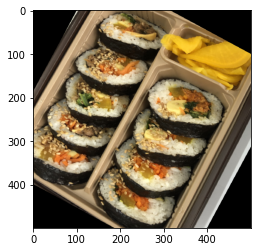


train label 27
train image: 


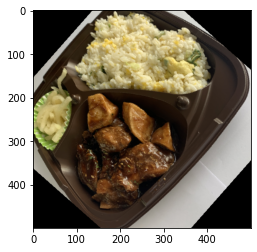


train label 83
train image: 


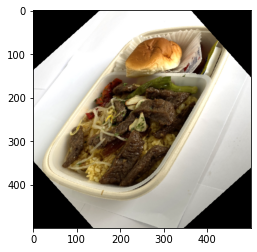


train label 101
train image: 


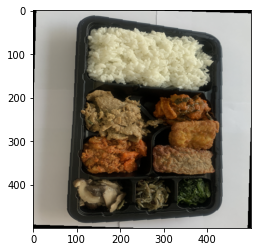


train label 62
train image: 


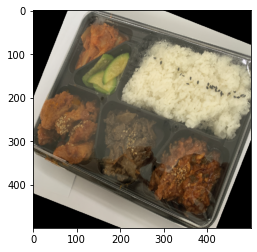


train label 57


KeyboardInterrupt: 

In [31]:
# 배치로 표시가 되기 때문에 [0]으로 배치의 첫번째만 확인한다.
# 위에서 배치사이즈 64로 했음.

classes = train_loader.dataset.classes

def process():
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        print('train image: ')
        custom_imshow(inputs[0])
        print()
        print('train label', classes[labels[0]])
        print('=====================')
        
process()

val image: 


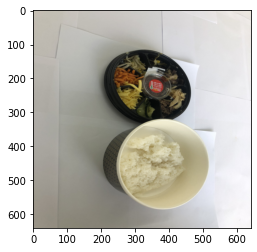


val label 56
val image: 


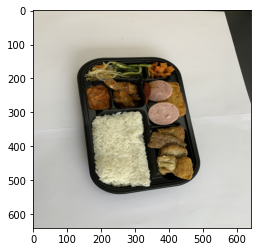


val label 1
val image: 


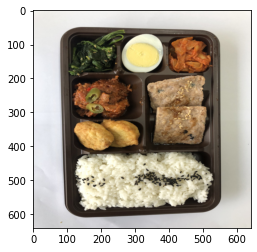


val label 25
val image: 


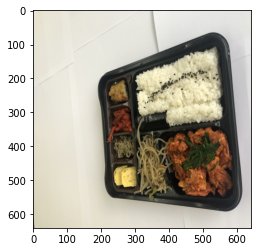


val label 31
val image: 


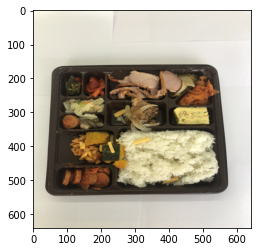


val label 53
val image: 


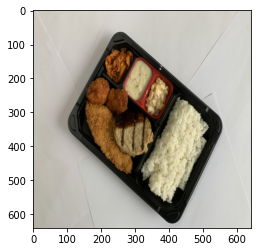


val label 17


KeyboardInterrupt: 

In [166]:
def process():
    for batch_idx, (inputs, labels) in enumerate(val_loader):
        print('val image: ')
        custom_imshow(inputs[0])
        print()
        print('val label', classes[labels[0]])
        print('=====================')
        
process()

In [188]:
train_loader.dataset.class_to_idx

{'1': 0,
 '10': 1,
 '100': 2,
 '101': 3,
 '102': 4,
 '103': 5,
 '104': 6,
 '105': 7,
 '106': 8,
 '11': 9,
 '12': 10,
 '13': 11,
 '14': 12,
 '15': 13,
 '16': 14,
 '17': 15,
 '18': 16,
 '19': 17,
 '2': 18,
 '20': 19,
 '21': 20,
 '23': 21,
 '24': 22,
 '25': 23,
 '27': 24,
 '28': 25,
 '29': 26,
 '3': 27,
 '30': 28,
 '31': 29,
 '32': 30,
 '33': 31,
 '34': 32,
 '35': 33,
 '36': 34,
 '37': 35,
 '38': 36,
 '39': 37,
 '4': 38,
 '40': 39,
 '41': 40,
 '42': 41,
 '43': 42,
 '44': 43,
 '45': 44,
 '46': 45,
 '47': 46,
 '48': 47,
 '49': 48,
 '5': 49,
 '50': 50,
 '51': 51,
 '52': 52,
 '53': 53,
 '54': 54,
 '55': 55,
 '56': 56,
 '57': 57,
 '58': 58,
 '59': 59,
 '6': 60,
 '60': 61,
 '61': 62,
 '62': 63,
 '63': 64,
 '64': 65,
 '65': 66,
 '66': 67,
 '67': 68,
 '68': 69,
 '69': 70,
 '7': 71,
 '70': 72,
 '71': 73,
 '72': 74,
 '73': 75,
 '74': 76,
 '75': 77,
 '76': 78,
 '77': 79,
 '78': 80,
 '79': 81,
 '8': 82,
 '80': 83,
 '81': 84,
 '82': 85,
 '83': 86,
 '85': 87,
 '86': 88,
 '87': 89,
 '88': 90,
 '89': 91,

In [191]:
idx2class = {v: k for k, v in train_loader.dataset.class_to_idx.items()}
idx2class

{0: '1',
 1: '10',
 2: '100',
 3: '101',
 4: '102',
 5: '103',
 6: '104',
 7: '105',
 8: '106',
 9: '11',
 10: '12',
 11: '13',
 12: '14',
 13: '15',
 14: '16',
 15: '17',
 16: '18',
 17: '19',
 18: '2',
 19: '20',
 20: '21',
 21: '23',
 22: '24',
 23: '25',
 24: '27',
 25: '28',
 26: '29',
 27: '3',
 28: '30',
 29: '31',
 30: '32',
 31: '33',
 32: '34',
 33: '35',
 34: '36',
 35: '37',
 36: '38',
 37: '39',
 38: '4',
 39: '40',
 40: '41',
 41: '42',
 42: '43',
 43: '44',
 44: '45',
 45: '46',
 46: '47',
 47: '48',
 48: '49',
 49: '5',
 50: '50',
 51: '51',
 52: '52',
 53: '53',
 54: '54',
 55: '55',
 56: '56',
 57: '57',
 58: '58',
 59: '59',
 60: '6',
 61: '60',
 62: '61',
 63: '62',
 64: '63',
 65: '64',
 66: '65',
 67: '66',
 68: '67',
 69: '68',
 70: '69',
 71: '7',
 72: '70',
 73: '71',
 74: '72',
 75: '73',
 76: '74',
 77: '75',
 78: '76',
 79: '77',
 80: '78',
 81: '79',
 82: '8',
 83: '80',
 84: '81',
 85: '82',
 86: '83',
 87: '85',
 88: '86',
 89: '87',
 90: '88',
 91: '89',

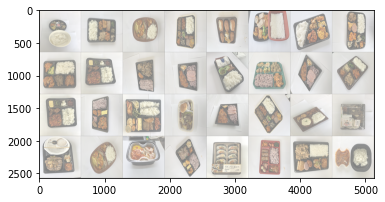

NameError: name 'batch_size' is not defined

In [157]:
# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

tensor([ 83,  45,  80,  78,  70,   0,  65,  93,  19,   2,  49,  25,  22, 102,
         46,  24,   1,  56,   7,  19,  10,  44,  58,  46,  28,  95,  79,  23,
         40,  64,   6,  51])


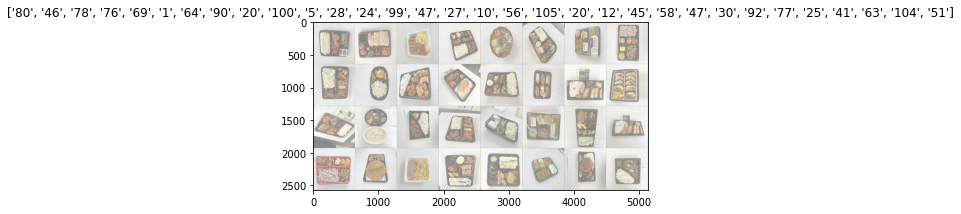

In [125]:
inputs,classes = next(iter(train_loader))
print(classes)

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.5,0.5,0.5])
    std = np.array([0.5,0.5,0.5])
    inp = std*inp+mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[train_loader.dataset.classes[x] for x in classes])

### 파이토치 내장 or 다운 모델 학습

In [5]:
from torchvision import models
dir(models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'utils',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vg

In [6]:
mobilenet_v2_ft = models.mobilenet_v2(pretrained=True)
print(mobilenet_v2_ft)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [92]:
# !pip install vision_transformer_pytorch

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [104]:
# from vision_transformer_pytorch import VisionTransformer
# vit = VisionTransformer.from_name('ViT-L_32')
# vit

VisionTransformer(
  (embedding): Conv2d(3, 1024, kernel_size=(32, 32), stride=(32, 32))
  (transformer): Encoder(
    (pos_embedding): PositionEmbs(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder_layers): ModuleList(
      (0): EncoderBlock(
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): SelfAttention(
          (query): LinearGeneral()
          (key): LinearGeneral()
          (value): LinearGeneral()
          (out): LinearGeneral()
        )
        (dropout): Dropout(p=0.1, inplace=False)
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): MlpBlock(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (act): GELU()
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (1): EncoderBlock(
        (norm1): LayerNorm((

In [93]:
# !pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16445 sha256=61b2c409ea9fb01be773173430c10f906fe724e29ce2cba8804eb9da8e43e527
  Stored in directory: /root/.cache/pip/wheels/63/17/7e/07f1c55a623c96ba9b291c5d2e4901afffb953b032c2470ca6
Successfully built efficientnet-pytorch
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [95]:
# from efficientnet_pytorch import EfficientNet
# efnet = EfficientNet.from_pretrained('efficientnet-b0')
# efnet

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [23]:
# # resnet
# wide_resnet101_2_ft.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [12]:
# # densenet
# densenet201_ft.classifier.in_features

ModuleAttributeError: 'Sequential' object has no attribute 'in_features'

In [122]:
# mobilenet_v2
mobilenet_v2_ft.classifier[1]

Linear(in_features=1280, out_features=1000, bias=True)

In [105]:
# # vit
# vit.classifier

Linear(in_features=1024, out_features=1000, bias=True)

In [103]:
# efnet.add_module

<bound method Module.add_module of EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePa

### 모델 뒷레이어인 classifier수정

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # resnet classifier tunning
# num_ftrs = wide_resnet101_2_ft.fc.in_features 
# wide_resnet101_2_ft.fc = nn.Linear(num_ftrs, len(train_loader.dataset.classes)) 

# # densenet classifier tunning
# num_ftr = densenet201_ft.classifier.in_features
# densenet201_ft.classifier = nn.Linear(num_ftr, len(train_loader.dataset.classes))

# mobilenet_v2 classifier tunning
mobilenet_v2_ft.classifier[1] = torch.nn.Linear(in_features=1280, out_features=len(train_loader.dataset.classes), bias=True) 

# # vit classifier tunning
# vit.classifier = nn.Linear(in_features=768, out_features=len(train_loader.dataset.classes), bias=True)

mobilenet_v2_ft = mobilenet_v2_ft.to(device)

In [ ]:
### 멀티 GPU 사용

# os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# print('Device:', device)
# print('Current cuda device:', torch.cuda.current_device())
# print('Count of using GPUs:', torch.cuda.device_count())

# # https://pytorch.org/hub/pytorch_vision_wide_resnet/

# model_ft = models.wide_resnet101_2(pretrained=True)
# print(model_ft)

# num_ftrs = model_ft.fc.in_features
# print('num_ftrs: ', num_ftrs)
# model_ft.fc = nn.Linear(num_ftrs, len(train_loader.dataset.classes)) 
# model_ft = model_ft.to(device)
# model_ft = nn.DataParallel(model_ft).to(device)

In [8]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(mobilenet_v2_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [37]:
!pwd

/data/FoodDetection/Object_Detection/yolov5-test/yolov5


In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time() #시작 시간을 기록(총 소요 시간 계산을 위해)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1)) #epoch를 카운트
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:  #train mode와 validation mode 순으로 진행
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]): #dataloader로부터 dataset과 그에 해당되는 label을 불러옴
                inputs = inputs.to(device) #GPU로 입력데이터를 올림
                labels = labels.to(device) #GPU로 label을 올림

                # zero the parameter gradients
                optimizer.zero_grad() #Gradient를 0으로 초기화

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) #마지막 layer에서 가장 값이 큰 1개의 class를 예측 값으로 지정
                    loss = criterion(outputs, labels) 

                    # backward + optimize only if in training phase
                    if phase == 'train': # training 모드에서는 weight를 update한다.
                        loss.backward() #backward
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # 모델 저장
            if epoch in list(range(0,num_epochs+1,30)):
                print(f'({epoch} 학습 중, Saving model ...')
                path = f'./gpu01_dataset/classification_model/{model}_{epoch}_checkpoint.pt'
                torch.save(model.state_dict(), path)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [110]:
data_dir = '/data/Data_data/FoodDetection/data/food_detection/LunchBox/data'
dataset, train_loader, val_loader = SubsetRandomSampler_train_val(data_dir, .1)

num_dataset: 17704
split:  1770
len(train_idx):  15934 , len(val_idx):  1770
len(train_loader):  1992 , len(val_loader):  222


In [ ]:
dataloaders = {'train':train_loader, 'val':val_loader}

mobilenet_v2_ft = train_model(mobilenet_v2_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=200)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/498 [00:00<?, ?it/s]

Epoch 0/199
----------


  4%|▎         | 18/498 [02:44<1:12:14,  9.03s/it]

### 훈련결과 시각화

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()